<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/posterior-acceptance-%2B-restructuring/mcmc/run_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Running the mcmc algorithm notebook to load it in
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/mcmc_algorithm.ipynb'

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

supernova_df.head()

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

supernova_df.head()

,CID,Z,c,cerr,x1,x1err,x0,x0err,mb,mberr,MU,MUERR,covx0x1,covx0c,covx1c
0,90O,0.0306,-0.0615,0.0324,0.3063,0.3943,0.005963,0.000209,16.210047,0.038083,35.547001,0.106,0.000010,-0.000005,-0.003592
1,93B,0.0707,0.0594,0.0376,-0.6927,0.3300,0.000736,0.000035,18.469965,0.051633,37.396999,0.120,0.000001,-0.000001,-0.001280
2,92P,0.0263,-0.0777,0.0287,0.1607,0.4422,0.006898,0.000143,16.053383,0.022515,35.415001,0.097,-0.000016,-0.000003,-0.001496
3,93H,0.0248,0.1963,0.0412,-2.8668,0.2425,0.003563,0.000169,16.743837,0.051566,35.095001,0.139,0.000007,-0.000006,-0.002212
4,93O,0.0519,-0.0666,0.0271,-0.9641,0.2376,0.001618,0.000035,17.626810,0.023160,36.840000,0.086,-0.000004,-0.000001,0.000531


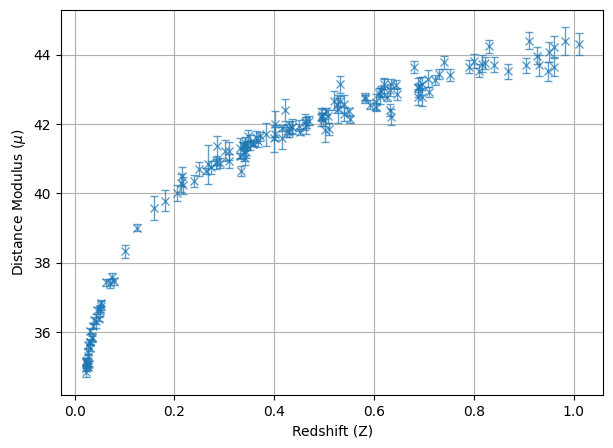

In [24]:
#quick plots of redshift against distance mod and error
plt.figure(figsize = (7,5))
plt.errorbar(redshift,distance_mod,err_distance_mod, linestyle = 'None', marker = 'x', elinewidth=1, capsize=3, capthick=1, alpha=0.7)
plt.xlabel('Redshift (Z)')
plt.ylabel('Distance Modulus $(\mu)$')
plt.grid()
plt.show()

In [25]:
#Testing the MCMC algorithm on multiple walkers now
n_steps = 10000
initial_params = [
    [0.25, 0.65],
    [0.26, 0.66],
    [0.24, 0.64],
    [0.25, 0.67],
    [0.26, 0.65]
]


step_size = [0.005, 0.005]

samples = metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, n_steps, initial_params, step_size, 0.2, 5)


MCMC carried out with 10000 steps, and acceptance ratio of each walker [0.4341 0.4352 0.4272 0.4319 0.4325]


[[[0.24513526 0.84652141]
  [0.20691969 0.84398233]
  [0.28820205 0.84177818]
  [0.26408488 0.83936054]
  [0.30326914 0.83812594]]

 [[0.24513526 0.84652141]
  [0.20691969 0.84398233]
  [0.28820205 0.84177818]
  [0.26408488 0.83936054]
  [0.30326914 0.83812594]]

 [[0.24513526 0.84652141]
  [0.20232848 0.84535383]
  [0.28592419 0.84263195]
  [0.26408488 0.83936054]
  [0.30185038 0.83548887]]

 ...

 [[0.23388851 0.84257276]
  [0.26293542 0.83986223]
  [0.24929744 0.8422176 ]
  [0.26165695 0.83878048]
  [0.27193507 0.84220772]]

 [[0.23310418 0.83818238]
  [0.26293542 0.83986223]
  [0.24562021 0.84148228]
  [0.26165695 0.83878048]
  [0.27193507 0.84220772]]

 [[0.23310418 0.83818238]
  [0.26511631 0.84066359]
  [0.25164959 0.8418449 ]
  [0.26238183 0.84096098]
  [0.27193507 0.84220772]]]


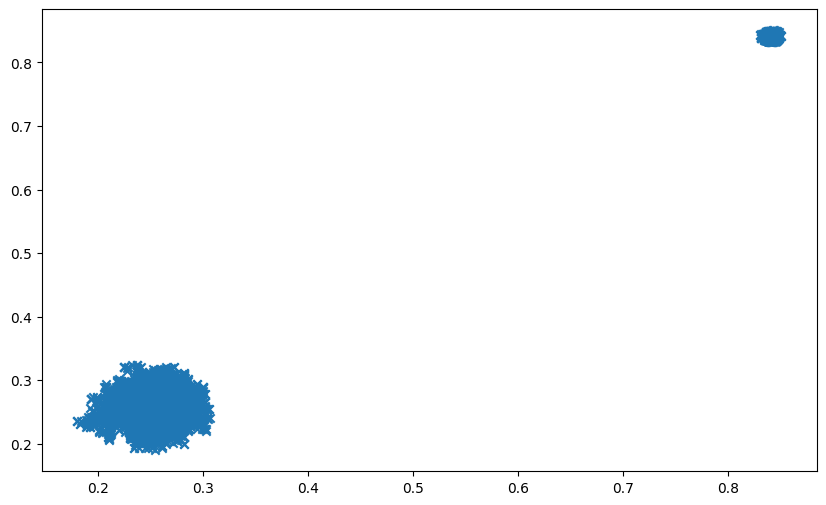

In [26]:
#Inspecting the values

print(samples)
samples.shape
plt.figure(figsize = (10,6))
plt.scatter(samples[:,0],samples[:,1], marker = 'x')
plt.show()

#idk some kind of visualisation of the values, lets me see it

In [28]:
!pip install corner

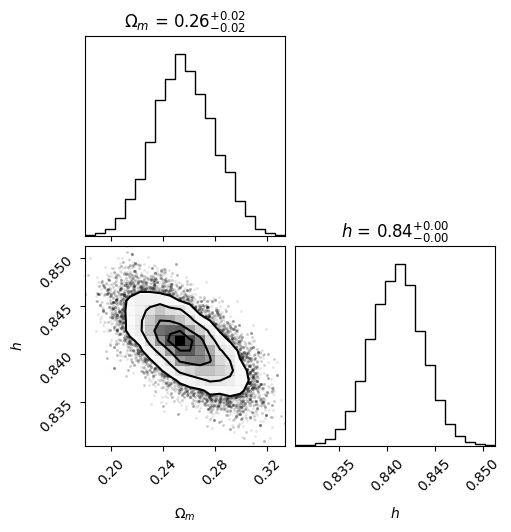

In [29]:
import corner

all_samples = samples.reshape(-1, 2)  #shape is (n_steps_post * n_walkers, 2)

figure = corner.corner(all_samples, labels=["$\Omega_m$", "$h$"],
                         show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
#Trace plot of the walkers
#Trying with one first
#samples gives an array
walker_1 = samples[:,0,:]
walker_1_h = walker_1[:,0] #every value of walker 1 across each iteraiton for the h
iterations = np.arange(samples.shape[0])


plt.figure(figsize = (10,6))
plt.plot(iterations, walker_1[:,0])
plt.title('walker 1 parameter space through iterations')

#once MCMC finalised try to get a trace of all the walkers for each paramater using a for loop and put on the same graph
